In [25]:
from all_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from mango import scheduler, Tuner
import random
import torch
torch.set_float32_matmul_precision('medium')

def objective(args_list):
    global train_v_data, train_v_real, test_v_data, test_v_real
    results = []
    params_evaluated = []
    for params in args_list:
        try:
            predictor = DeepAREstimator(
                prediction_length=12, freq="M", 
                context_length = int(params['context_length']),
                num_layers=params["num_layers"],
                # hidden_size=params["hidden_size"],
                batch_size= int(params['mini_batch_size']),
                dropout_rate = params['dropout_rate'],
                # num_cells = int(params['num_cells']),
                # num_layers = int(params['num_layers']),
                # embedding_dimension = int(params['embedding_dimension']),
                trainer_kwargs={
                    # "learning_rate": params['learning_rate'],
                    "accelerator": "gpu",
                    "enable_progress_bar": False,
                    "enable_model_summary": False,
                    "max_epochs": params['max_epochs']
                    # "mini_batch_size": int(params['mini_batch_size']),
                    }
            ).train(train_v_data)
            
            forecast_it = list(predictor.predict(test_v_data.input, num_samples=100))

            all_forecasts = []
            for forecast in forecast_it:
                all_forecasts.append(forecast.mean)
            
            _, mean, std = rolling_window_series(train_v_real, 12)
            preds_real = znorm_reverse(all_forecasts[0], mean, std)

            rmse_result = rmse(test_v_real, preds_real)
            params_evaluated.append(params)
            results.append(rmse_result)
        except:
            continue
    return results


def find_best_parameter(train_norm, test_norm, train_real, test_real):
    global train_v_data, train_v_real, test_v_data, test_v_real

    params_space = {
        'context_length': range(1,200),
        # 'learning_rate': np.logspace(-5, -1, 10),
        'mini_batch_size': range(32, 1029, 32),
        # 'num_cells': range(30, 201, 10),
        'num_layers': range(1, 9),
        'dropout_rate': np.linspace(0.0, 0.2, 5),
        "max_epochs": [50]
        # 'embedding_dimension': range(1, 51)
    }
    conf_Dict = dict()
    conf_Dict['num_iteration'] = 15
    train_v_data = train_norm
    train_v_real = train_real
    test_v_data = test_norm
    test_v_real = test_real

    tuner = Tuner(params_space, objective, conf_Dict)
    results_arima = tuner.minimize()

    return results_arima

def get_train_test_deepar(train_norm, test_norm):
    concat_norm = pd.concat([train_norm, test_norm])
    dataset_norm = PandasDataset(concat_norm, target="value")
    # test_ds = PandasDataset(test_norm, target="value")
    training_data, test_gen = split(dataset_norm, offset=-12)
    test_data = test_gen.generate_instances(prediction_length=12, windows=1)
    return training_data, test_data

def set_seed(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

# Definir a semente desejada
seed_value = 42
set_seed(seed_value)

In [26]:
global horizon
window = 12
horizon = 12
derivado = "gasolinac"
estado = "AC"
df = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(df, horizon)
#{'context_length': 12, 'num_layers': 2, 'batch_size': 32, 'max_epochs': 30, 'num_batches_per_epoch': 20}

In [27]:
train_val, test_val = train_test_stats(train, horizon)

#treino
train_tf, mean, std = rolling_window_series(train, horizon)
test_tf = znorm_mean_std(test, mean, std)
train_data, test_data = get_train_test_deepar(train_tf, test_tf)

#validacao
train_val_tf, mean_val, std_val = rolling_window_series(train_val, horizon)

test_val_tf = znorm_mean_std(test_val, mean_val, std_val)
train_data_val, test_data_val = get_train_test_deepar(train_val_tf, test_val_tf)

# results = find_best_parameter(train_data_val, test_data_val, train_val, test_val)

predictor = DeepAREstimator(
                                prediction_length=12,
                                context_length = 12,
                                num_layers = 2,
                                num_batches_per_epoch=20,
                                batch_size= 32,
                                # hidden_size=saved_params['hidden_size'],
                                # lr=saved_params['lr'],
                                # dropout_rate = saved_params['dropout_rate'],
                                freq="M", 
                                trainer_kwargs={
                                    # "learning_rate":
                                    "max_epochs": 30,
                                    # "strategy": saved_params["strategy"],
                                    "devices": [1],
                                    "enable_progress_bar": False,
                                    "enable_model_summary": False,
                                    "accelerator": "gpu"
                                    }
                            ).train(train_data)
                        
forecasts_it = list(predictor.predict(test_data.input, num_samples=100))
all_forecasts = []
for forecast in forecasts_it:
    all_forecasts.append(forecast.mean)

reversed = znorm_reverse(all_forecasts[0], mean, std)
print(reversed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0, global step 20: 'train_loss' reached 1.50107 (best 1.50107), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_1/checkpoints/epoch=0-step=20.ckpt' as top 1
Epoch 1, global step 40: 'train_loss' reached 1.39823 (best 1.39823), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_1/checkpoints/epoch=1-step=40.ckpt' as top 1
Epoch 2, global step 60: 'train_loss' reached 1.26236 (best 1.26236), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_1/checkpoints/epoch=2-step=60.ckpt' as top 1
Epoch 3, global step 80: 'train_loss' reached 1.18479 (best 1.18479), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_1/checkpoints/epoch=3-step=80.ckpt' as top 1
Epoch 4, global step 100: 'train_loss' reached 1.13680 (best 1.13680), saving model to '/exp/lucas/Statistics_and_Seq2Seq/lightning_logs/version_1/checkpoints/epoch=4-step=100.ckpt' as top 1
Epoch 5, global step 120: 'train_loss' reached 1.0633

[10830.439 10208.772 10574.803 10700.212 11196.324 12557.664 12696.916
 11828.39  12263.356 12125.46  11200.606 10545.11 ]


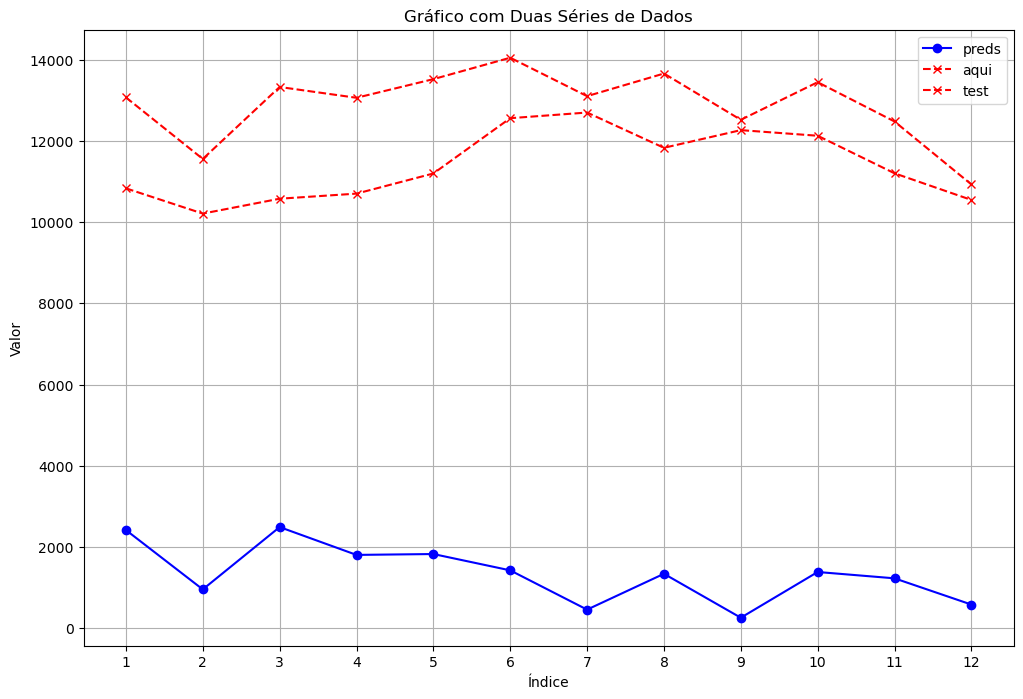

In [28]:
import matplotlib.pyplot as plt

# Dados fornecidos
dados1 = [2416.2685546875, 955.185546875, 2489.9601562499993, 1804.6279296875, 1826.025390625, 1424.00390625, 457.24648437500036, 1339.693359375, 257.87734375000036, 1383.775390625, 1227.9177734375007, 581.9658203125]
dados2 = reversed
dados3 = test

# Criar uma lista de índices para o eixo x
indices = list(range(1, len(dados1) + 1))

# Criar o gráfico
plt.figure(figsize=(12, 8))

# Plotar a primeira série de dados
plt.plot(indices, dados1, marker='o', linestyle='-', color='b', label='preds')

# Plotar a segunda série de dados
plt.plot(indices, dados2, marker='x', linestyle='--', color='r', label='aqui')

plt.plot(indices, dados3, marker='x', linestyle='--', color='r', label='test')
# Adicionar título e rótulos aos eixos
plt.title('Gráfico com Duas Séries de Dados')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Adicionar a legenda
plt.legend()

# Exibir a grade e o gráfico
plt.grid(True)
plt.xticks(indices)  # Exibir todos os índices no eixo x
plt.show()
